# 02. Neural Network classification with PyTorch

## 1. Data (Making data)

In [ ]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=69)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[-0.51839217 -0.66522091]
 [ 0.78398275 -0.00098577]
 [ 0.12616247 -0.75963138]
 [-0.70384469 -0.32717022]
 [ 0.67524498 -0.34785267]]
First 5 samples of y:
 [1 1 1 1 1]


In [ ]:
import torch
torch.tensor(y).unique(return_counts=True)

(tensor([0, 1]), tensor([500, 500]))

In [ ]:
# Make a dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2" : X[:, 1],
                        "label" : y})
circles.head(20)

,X1,X2,label
0,-0.518392,-0.665221,1
1,0.783983,-0.000986,1
2,0.126162,-0.759631,1
3,-0.703845,-0.327170,1
4,0.675245,-0.347853,1
5,-0.750599,-0.141688,1
6,0.721272,-0.431657,1
7,-0.625116,0.572249,1
8,0.983314,0.248923,0
9,0.251079,0.962878,0


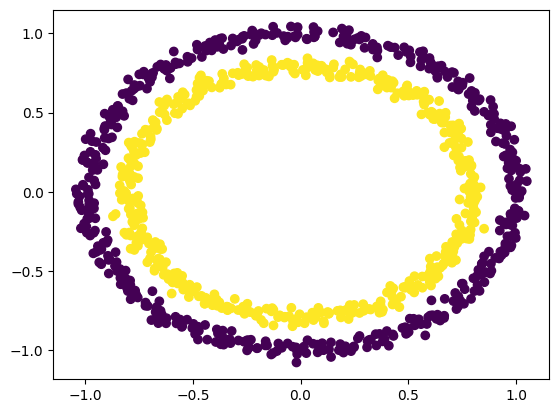

In [ ]:
# Vizualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y)

Note: the data we're working with is often referred to as a "toy dataset" that is small enough to experiment with but large enough to practice with

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"The above have shaoes {X_sample.shape} and {y_sample.shape}, respectively")

Values for one sample of X: [-0.51839217 -0.66522091] and the same for y: 1
The above have shaoes (2,) and (), respectively


### 1.2 Turn data into tensors and create train/test split

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[-0.5184, -0.6652],
         [ 0.7840, -0.0010],
         [ 0.1262, -0.7596],
         [-0.7038, -0.3272],
         [ 0.6752, -0.3479]]),
 tensor([1., 1., 1., 1., 1.]))

In [ ]:
# Split data into train/test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=69)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

To build the classification model:
1. Setup device agnostic code
2. Construct a model (by subclassing `nn.Module`)
3. define a loss function & optimizer
4. Create a training & test loop

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # Create 2 nn.Linear layers capable of handling the shape of our data
    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)

  # Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer2(self.layer1(x))

# Instantiate instance of model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device, next(model_0.parameters()).device

('cuda', device(type='cuda', index=0))

In [ ]:
# Let's replicate the model above using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3152,  0.5441],
                      [-0.2224,  0.2816],
                      [-0.0369, -0.2793],
                      [-0.1060,  0.1628],
                      [-0.0293, -0.6602]], device='cuda:0')),
             ('0.bias',
              tensor([ 5.2247e-01, -5.0344e-01, -2.9500e-02, -6.1587e-01, -6.0439e-05],
                     device='cuda:0')),
             ('1.weight',
              tensor([[-0.1610, -0.3112, -0.0137, -0.1404,  0.3437]], device='cuda:0')),
             ('1.bias', tensor([-0.0513], device='cuda:0'))])

In [ ]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {y_test.shape}")
print(untrained_preds[:10])
print(y_test[:10])

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])
tensor([[ 0.2370],
        [-0.0535],
        [ 0.5124],
        [ 0.5454],
        [-0.1556],
        [-0.1277],
        [-0.2027],
        [-0.0093],
        [ 0.3179],
        [-0.1028]], device='cuda:0')
tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 0.])


## 2.1 Pick a loss function & optimizer

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # has the sigmoid activation function built in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy - what % does the model get right
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 3. Train model

1. Forward pass
2. Calculate loss
3. Optimier zero grad
4. Loss backward (backprop)
5. Gradient descent

### 3.1 Going from raw logits (model outputs) -> prediction probabilities (after activation function) -> prediction labels

In [ ]:
with torch.inference_mode():
  y_preds = torch.round(  # 3. round to make the prediction probabilities actual predictions
      torch.sigmoid( # 2. Apply sigmoid activation function
          model_0(X_test.to(device))[:5] # 1. get logits (model outputs)
        )
  )
y_preds

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.]], device='cuda:0')

### 3.2 building a training and test loop

In [ ]:
torch.manual_seed(69)
torch.cuda.manual_seed(69)

num_epochs = 10000
# epochs_list = []
# train_loss_list = []
# test_loss_list = []

# Device agnostic code for data
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(num_epochs):

  ### TRAIN ###
  model_0.train()

  # frwrd pass
  y_train_logits = model_0(X_train).squeeze()
  y_train_pred = torch.round(torch.sigmoid(y_train_logits)) # torch.sigmoid needs to be used

  # loss (note that nn.BCEWithLogitsLoss() expects logits) & accuracy
  loss = loss_fn(y_train_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_train_pred)

  # zero gradients
  optimizer.zero_grad()

  # backprop
  loss.backward()

  # gradient descent
  optimizer.step()

  ### TEST ###
  model_0.eval()
  with torch.inference_mode():
    # test preds (forwad pass)
    y_test_logits = model_0(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))

    # test loss & acc
    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=y_test_pred)

  ### PRINT ###
  ### PRINT STATEMENT ###
  if epoch % 1000 == 0:
    print(f"Epoch {epoch} | Train Loss: {loss} | Train Acc: {acc} | Test Loss: {test_loss} | Test Acc: {test_acc}")

Epoch 0 | Train Loss: 0.707364559173584 | Train Acc: 49.875 | Test Loss: 0.6934812664985657 | Test Acc: 54.0
Epoch 1000 | Train Loss: 0.6927129030227661 | Train Acc: 50.375 | Test Loss: 0.6968152523040771 | Test Acc: 39.0
Epoch 2000 | Train Loss: 0.6927078366279602 | Train Acc: 50.125 | Test Loss: 0.6971267461776733 | Test Acc: 41.0
Epoch 3000 | Train Loss: 0.6927076578140259 | Train Acc: 50.0 | Test Loss: 0.6971703171730042 | Test Acc: 41.0
Epoch 4000 | Train Loss: 0.6927076578140259 | Train Acc: 50.0 | Test Loss: 0.6971760988235474 | Test Acc: 41.5
Epoch 5000 | Train Loss: 0.6927076578140259 | Train Acc: 50.0 | Test Loss: 0.6971768736839294 | Test Acc: 41.5
Epoch 6000 | Train Loss: 0.6927076578140259 | Train Acc: 50.0 | Test Loss: 0.6971769332885742 | Test Acc: 41.5
Epoch 7000 | Train Loss: 0.6927077174186707 | Train Acc: 50.0 | Test Loss: 0.6971769332885742 | Test Acc: 41.5
Epoch 8000 | Train Loss: 0.6927077174186707 | Train Acc: 50.0 | Test Loss: 0.6971769332885742 | Test Acc: 41.5

In [ ]:
## 4. Make predictions
model_0.eval()
with torch.inference_mode():
  y_test_preds = model_0(X_test)

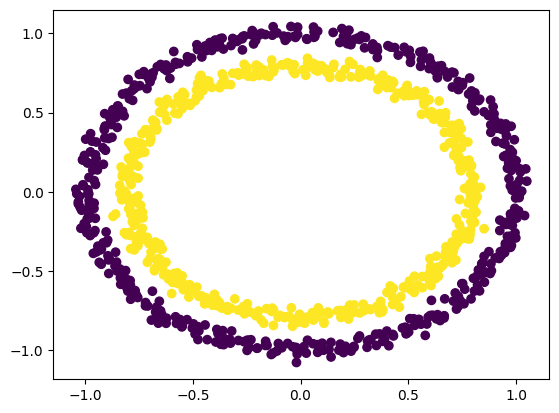

In [ ]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y)

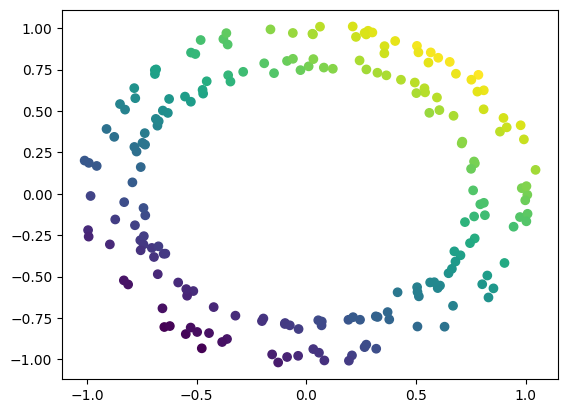

In [ ]:
plt.scatter(x=X_test.cpu()[:,0],
            y=X_test.cpu()[:,1],
            c=y_test_preds.cpu().numpy())

## 5. Improving a model

Possible strategies:
* Add more layers
* Add more hidden units
* Fit for longer
* Changing the activation function
* Change the learning rate
* Change the loss function

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3008,  0.5201],
                      [-0.2490,  0.1596],
                      [-0.0731, -0.3365],
                      [-0.1059,  0.1309],
                      [-0.0343, -0.5627]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.5317, -0.4793, -0.0234, -0.6076, -0.0236], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0388, -0.1790, -0.1979, -0.0158, -0.0123]], device='cuda:0')),
             ('1.bias', tensor([-0.1500], device='cuda:0'))])

### 5.1 Create `model_1` using the more layers & hidden units

In [ ]:
# "Improved" model using the strategies listed above

class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=124)
    self.layer_2 = nn.Linear(in_features=124, out_features=124)
    self.layer_3 = nn.Linear(in_features=124, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=124, bias=True)
  (layer_2): Linear(in_features=124, out_features=124, bias=True)
  (layer_3): Linear(in_features=124, out_features=1, bias=True)
)

In [ ]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 4.8053e-01,  4.3013e-01],
                      [-5.3551e-01,  4.3728e-02],
                      [ 2.3285e-01, -1.3047e-01],
                      [-5.8157e-01, -3.6361e-01],
                      [ 2.9039e-01,  1.7203e-01],
                      [ 5.9223e-01, -6.8093e-01],
                      [ 5.2910e-01, -6.2792e-01],
                      [ 6.5895e-01, -6.9680e-01],
                      [-1.9396e-01, -1.1358e-01],
                      [ 2.0420e-01, -6.9305e-01],
                      [ 1.3082e-01,  6.5491e-01],
                      [ 2.7685e-01,  5.8783e-01],
                      [ 7.4019e-02, -3.7563e-01],
                      [-2.4575e-01, -6.7712e-02],
                      [ 2.8561e-01,  1.8012e-01],
                      [-5.7343e-01,  4.9849e-01],
                      [-2.0189e-01,  3.5244e-01],
                      [-2.0090e-01,  6.3995e-02],
                      [ 4.4848e-01, -6.2643e-01],
                  

In [ ]:
# Create a loss funciton
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                             lr=0.1)

In [ ]:
# training and evaluation loop for model_1
torch.manual_seed(69)
torch.cuda.manual_seed(69)

total_epochs = 10000

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(total_epochs):

  ### TRAIN ###
  model_1.train()

  # Forward Pass
  y_train_logits = model_1(X_train).squeeze()
  y_train_pred = torch.round(torch.sigmoid(y_train_logits))

  # loss (note that nn.BCEWithLogitsLoss() expects logits) & accuracy
  loss = loss_fn(y_train_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_train_pred)

  # zero gradients
  optimizer.zero_grad()

  # backprop
  loss.backward()

  # gradient descent
  optimizer.step()

  ### TEST ###
  model_1.eval()
  with torch.inference_mode():
    # test preds (forwad pass)
    y_test_logits = model_1(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))

    # test loss & acc
    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=y_test_pred)


  ### PRINT ###
  if epoch % 1000 == 0:
    print(f"Epoch {epoch} | Train Loss: {loss} | Train Acc: {acc} | Test Loss: {test_loss} | Test Acc: {test_acc}")


Epoch 0 | Train Loss: 0.6944764256477356 | Train Acc: 49.25 | Test Loss: 0.6947120428085327 | Test Acc: 51.5
Epoch 1000 | Train Loss: 0.6927076578140259 | Train Acc: 50.0 | Test Loss: 0.6971769332885742 | Test Acc: 41.5
Epoch 2000 | Train Loss: 0.6927076578140259 | Train Acc: 50.0 | Test Loss: 0.6971769332885742 | Test Acc: 41.5
Epoch 3000 | Train Loss: 0.6927076578140259 | Train Acc: 50.0 | Test Loss: 0.6971769332885742 | Test Acc: 41.5
Epoch 4000 | Train Loss: 0.6927076578140259 | Train Acc: 50.0 | Test Loss: 0.6971769332885742 | Test Acc: 41.5
Epoch 5000 | Train Loss: 0.6927076578140259 | Train Acc: 50.0 | Test Loss: 0.6971769332885742 | Test Acc: 41.5
Epoch 6000 | Train Loss: 0.6927076578140259 | Train Acc: 50.0 | Test Loss: 0.6971769332885742 | Test Acc: 41.5
Epoch 7000 | Train Loss: 0.6927076578140259 | Train Acc: 50.0 | Test Loss: 0.6971769332885742 | Test Acc: 41.5
Epoch 8000 | Train Loss: 0.6927076578140259 | Train Acc: 50.0 | Test Loss: 0.6971769332885742 | Test Acc: 41.5
Epo

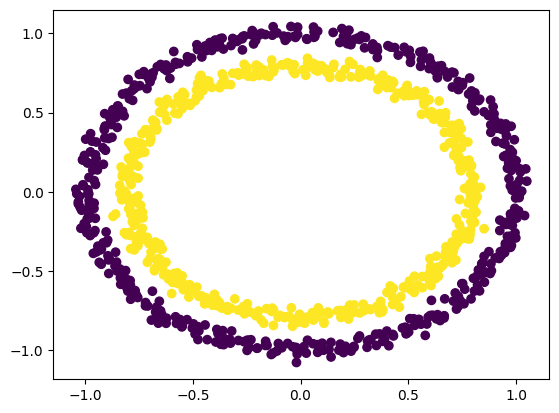

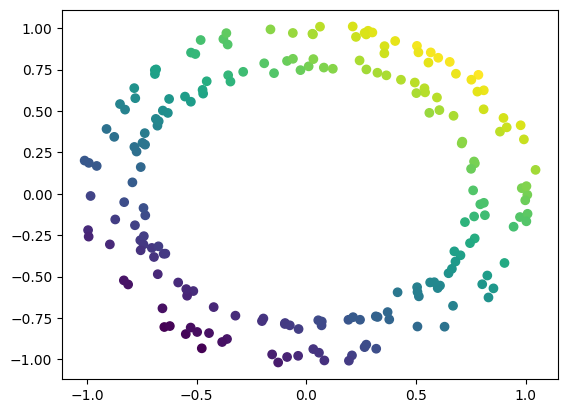

In [ ]:
## 4. Make predictions
model_1.eval()
with torch.inference_mode():
  y_test_preds = model_1(X_test)

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y)
plt.show()
plt.scatter(x=X_test.cpu()[:,0],
            y=X_test.cpu()[:,1],
            c=y_test_preds.cpu().numpy())
plt.show()

### Check if `model_1` is capable of learning patterns in a linear dataset

torch.Size([500, 1]) torch.Size([500, 1])


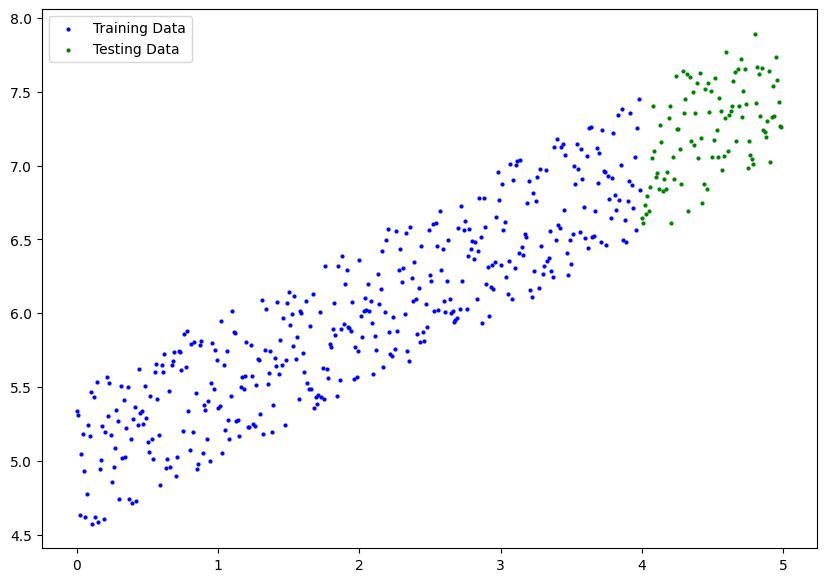

In [ ]:
### DATA CREATION & VISUALIZATION ###

# Create dummy data step
X = torch.arange(start = 0,
                 end = 5,
                 step = 0.01).unsqueeze(dim=1)
torch.manual_seed(69)
Y = torch.add(0.5 * X, torch.rand(X.shape)) + 4.5
print(X.shape, Y.shape)

# Train-Test Split
X_train, y_train = X[:400], Y[:400]
X_test, y_test = X[400:], Y[400:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Function to visualize data
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
  plt.scatter(test_data, test_labels, c="g", s=4,  label="Testing Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend()

plot_predictions()

### 5.2 adjusting `model_1` to fit the regression problem

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=128),
    nn.Linear(in_features=128, out_features=128),
    nn.Linear(in_features=128, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
# Choose loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [ ]:
### TRAIN/TEST LOOP ###

torch.manual_seed(69)
torch.cuda.manual_seed(69)

# Device Agnostic code for data
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

num_epochs = 15000

for epoch in range(num_epochs):

  ### TRAIN ###
  model_2.train()
  y_train_pred = model_2(X_train)
  loss = loss_fn(y_train_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### TEST ###
  model_2.eval()
  with torch.inference_mode():
    y_test_pred = model_2(X_test)
    test_loss = loss_fn(y_test_pred, y_test)

  ### PRINT ###
  if epoch % 1000 == 0:
    print(f"Epoch {epoch} | Loss: {loss} | Test Loss: {test_loss}")

# Print target equation outside of loop)
print("y = 0.5x + 5")

Epoch 0 | Loss: 6.562641620635986 | Test Loss: 4.497581481933594
Epoch 1000 | Loss: 0.8876814246177673 | Test Loss: 0.5448665618896484
Epoch 2000 | Loss: 0.7409391403198242 | Test Loss: 0.44995391368865967
Epoch 3000 | Loss: 0.5138290524482727 | Test Loss: 0.5059267282485962
Epoch 4000 | Loss: 0.3557274639606476 | Test Loss: 0.4770086705684662
Epoch 5000 | Loss: 0.27156221866607666 | Test Loss: 0.2595461905002594
Epoch 6000 | Loss: 0.27003681659698486 | Test Loss: 0.2557133734226227
Epoch 7000 | Loss: 0.26738739013671875 | Test Loss: 0.24763618409633636
Epoch 8000 | Loss: 0.25128382444381714 | Test Loss: 0.22445689141750336
Epoch 9000 | Loss: 0.25147947669029236 | Test Loss: 0.2245456874370575
Epoch 10000 | Loss: 0.2507365047931671 | Test Loss: 0.2250167429447174
Epoch 11000 | Loss: 0.2510281801223755 | Test Loss: 0.2248174548149109
Epoch 12000 | Loss: 0.2510480284690857 | Test Loss: 0.22492384910583496
Epoch 13000 | Loss: 0.25103995203971863 | Test Loss: 0.22489097714424133
Epoch 1400

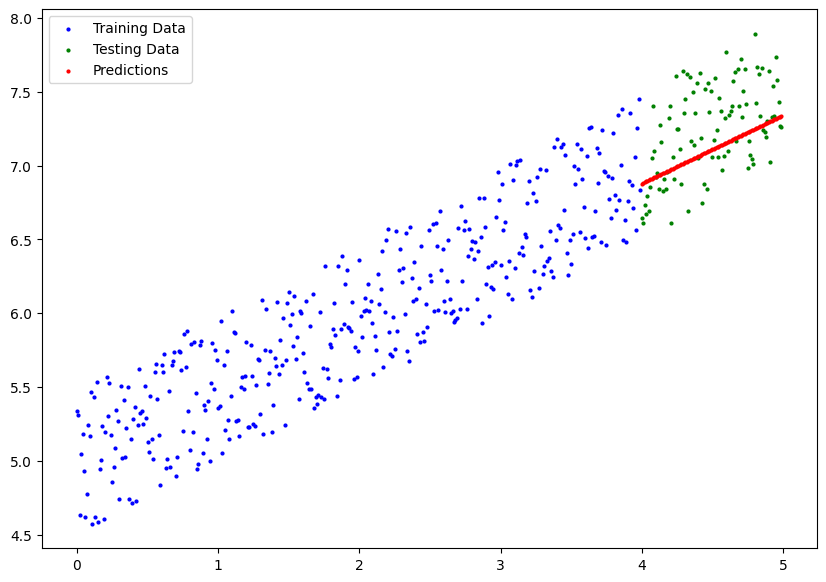

In [ ]:
model_2.eval()
with torch.inference_mode():
  y_test_pred = model_2(X_test)

plot_predictions(predictions=y_test_pred.cpu())

## 6. "The missing piece": Non Linearity

### 6.1 recreating Data

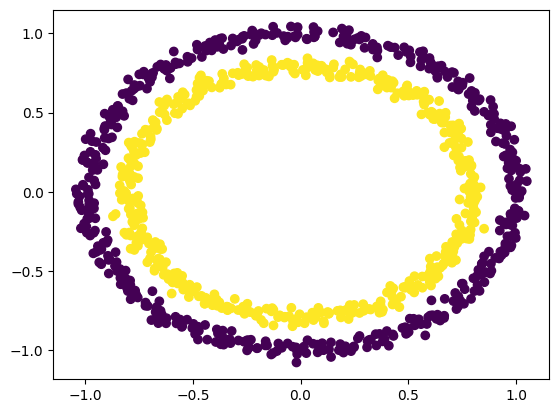

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=69)

plt.scatter(X[:, 0], X[:, 1], c=y)

In [ ]:
# Format data
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

X_train[:5], y_train[:5]

(tensor([[ 0.8034, -0.1072],
         [-0.2292,  0.9914],
         [-0.5869, -0.5160],
         [ 0.9750, -0.2808],
         [ 0.9769, -0.1566]]),
 tensor([1., 0., 1., 0., 0.]))

### 6.2 building a model with non-linearity

In [ ]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # non-linear activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)

In [ ]:
# Set a loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss() # has the sigmoid activation function built in

optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy - what % does the model get right
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
torch.manual_seed(69)
torch.cuda.manual_seed(69)

num_epochs = 10000
# epochs_list = []
# train_loss_list = []
# test_loss_list = []

# Device agnostic code for data
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(num_epochs):

  ### TRAIN ###
  model_3.train()

  # frwrd pass
  y_train_logits = model_3(X_train).squeeze()
  y_train_pred = torch.round(torch.sigmoid(y_train_logits)) # torch.sigmoid needs to be used

  # loss (note that nn.BCEWithLogitsLoss() expects logits) & accuracy
  loss = loss_fn(y_train_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_train_pred)

  # zero gradients
  optimizer.zero_grad()

  # backprop
  loss.backward()

  # gradient descent
  optimizer.step()

  ### TEST ###
  model_3.eval()
  with torch.inference_mode():
    # test preds (forwad pass)
    y_test_logits = model_3(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))

    # test loss & acc
    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=y_test_pred)

  ### PRINT ###
  ### PRINT STATEMENT ###
  if epoch % 1000 == 0:
    print(f"Epoch {epoch} | Train Loss: {loss} | Train Acc: {acc} | Test Loss: {test_loss} | Test Acc: {test_acc}")

Epoch 0 | Train Loss: 0.7006667256355286 | Train Acc: 49.25 | Test Loss: 0.6913374066352844 | Test Acc: 53.0
Epoch 1000 | Train Loss: 0.49558329582214355 | Train Acc: 94.75 | Test Loss: 0.5117372274398804 | Test Acc: 94.5
Epoch 2000 | Train Loss: 0.025486210361123085 | Train Acc: 100.0 | Test Loss: 0.02577327750623226 | Test Acc: 100.0
Epoch 3000 | Train Loss: 0.008776949718594551 | Train Acc: 100.0 | Test Loss: 0.009403305128216743 | Test Acc: 100.0
Epoch 4000 | Train Loss: 0.005009470507502556 | Train Acc: 100.0 | Test Loss: 0.005762243177741766 | Test Acc: 100.0
Epoch 5000 | Train Loss: 0.003452699165791273 | Train Acc: 100.0 | Test Loss: 0.004264096263796091 | Test Acc: 100.0
Epoch 6000 | Train Loss: 0.002609996823593974 | Train Acc: 100.0 | Test Loss: 0.003413580358028412 | Test Acc: 100.0
Epoch 7000 | Train Loss: 0.0020852135494351387 | Train Acc: 100.0 | Test Loss: 0.0028687140438705683 | Test Acc: 100.0
Epoch 8000 | Train Loss: 0.0017286677611991763 | Train Acc: 100.0 | Test Lo

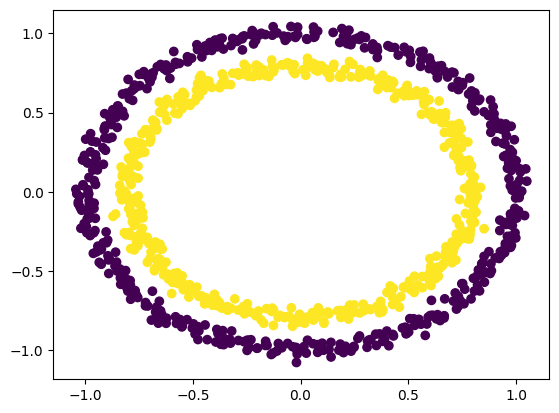

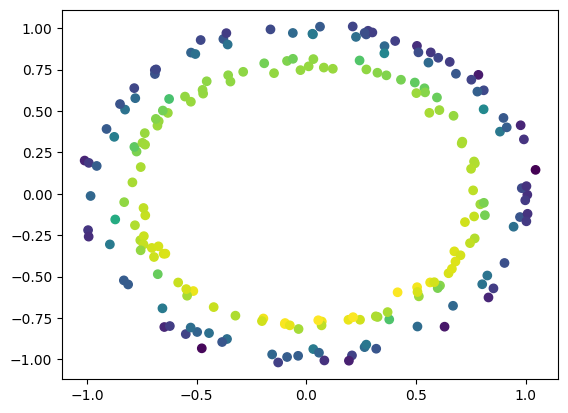

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_test_preds = model_3(X_test)

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y)
plt.show()
plt.scatter(x=X_test.cpu()[:,0],
            y=X_test.cpu()[:,1],
            c=y_test_preds.cpu().numpy())
plt.show()

## 7. Replicating non-linear activation functions

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

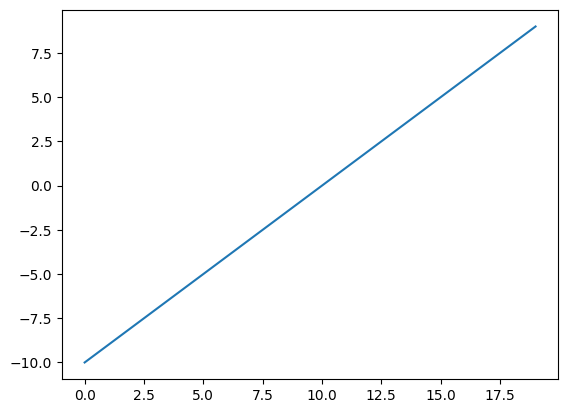

In [ ]:
plt.plot(A)

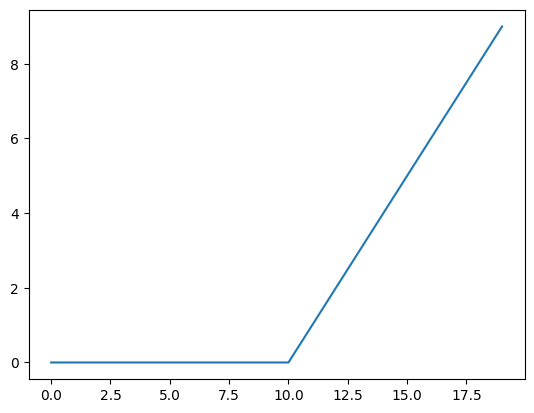

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

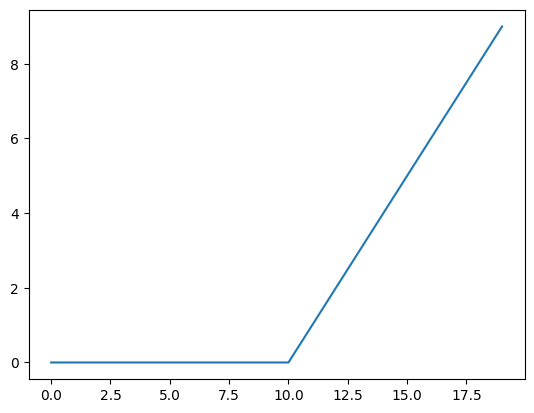

In [ ]:
plt.plot(relu(A))

In [ ]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

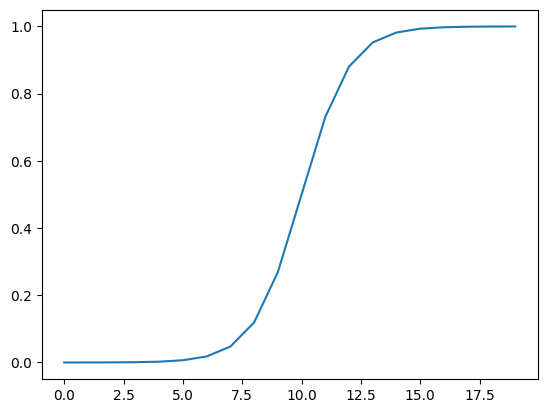

In [ ]:
plt.plot(torch.sigmoid(A))

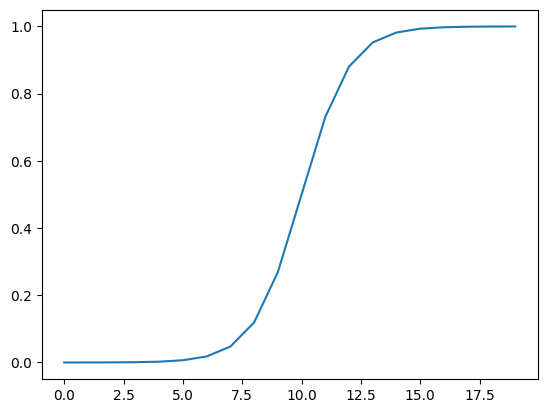

In [ ]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

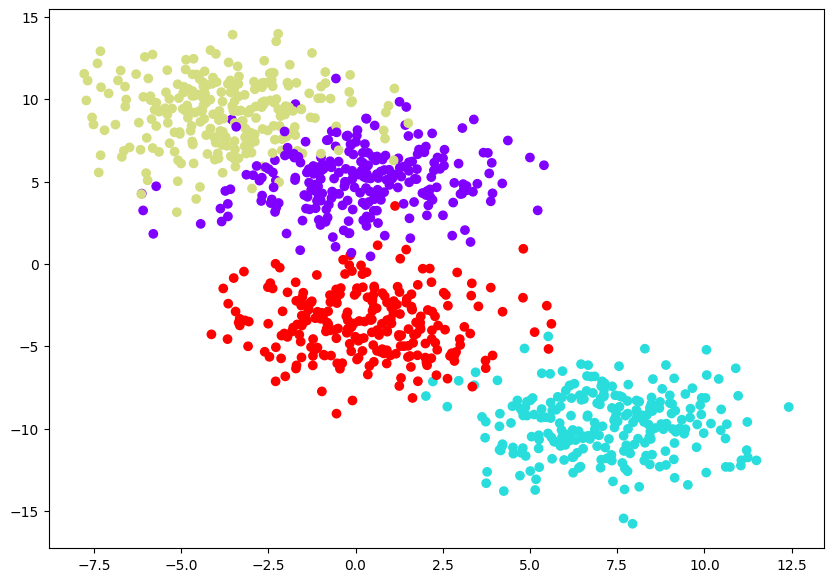

In [187]:
# Imports
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 14

# Create Data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.9,
                            random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# T/T Split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap="rainbow")

### 8.2 Building a multiclass classification model

In [188]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [189]:
# Build model
class BlobModel(nn.Module):
  def __init__(self, input_features: int, output_features: int, hidden_units=8):
    """Initializies classification model.

    Args:
      input_freatures (int): Number of input features to the model
      output_features (int): Number of output features to the model
      hidden_units (int): Number of hidden units between layers, default 8
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer_stack(x)

# Instantiate Model
blob_model_0 = BlobModel(input_features=2,
                         output_features=4).to(device)

In [190]:
blob_model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create loss function and optimizer

In [191]:
# Set loss function
loss_fn = nn.CrossEntropyLoss()

# Set optimizers
optimizer = torch.optim.SGD(params=blob_model_0.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities with `blob_model_0`

logits -> pred probs -> labels

In [192]:
blob_model_0.eval()
with torch.inference_mode():
  y_logits = blob_model_0(X_test) # logits

In [193]:
y_blob_test[:5], y_logits[:5]

(tensor([2, 3, 0, 1, 0]),
 tensor([[ 0.3113,  0.1597, -0.2805, -0.3235],
         [ 0.3483,  0.0780, -0.2450, -0.3059],
         [ 0.2774,  0.0739, -0.2134, -0.0415],
         [ 0.2866,  0.0805, -0.2067, -0.0303],
         [ 0.3648,  0.0202, -0.2066, -0.2406]], device='cuda:0'))

In [194]:
# logits -> pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[0.3398, 0.2920, 0.1880, 0.1801],
        [0.3527, 0.2691, 0.1949, 0.1833],
        [0.3170, 0.2586, 0.1940, 0.2304],
        [0.3172, 0.2581, 0.1937, 0.2310],
        [0.3547, 0.2513, 0.2003, 0.1936]], device='cuda:0')

In [195]:
# pred_probs -> labels
y_labels = torch.argmax(y_pred_probs, dim=1)
y_labels[:5]

tensor([0, 0, 0, 0, 0], device='cuda:0')

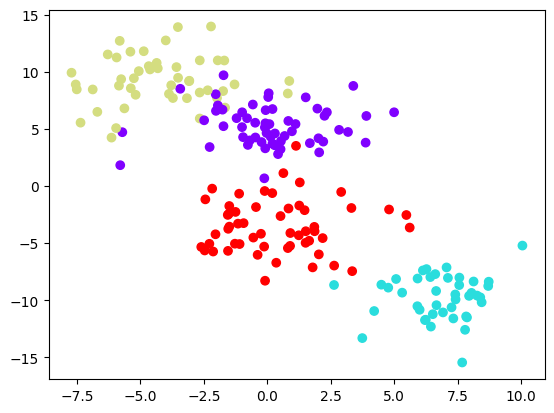

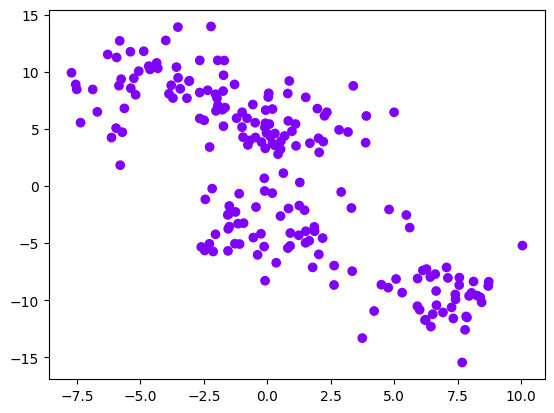

In [196]:
# Visualize!
plt.scatter(X_blob_test[:, 0], X_blob_test[:, 1], c=y_blob_test, cmap="rainbow")
plt.show()
plt.scatter(X_blob_test[:, 0], X_blob_test[:, 1], c=y_labels.cpu(), cmap="rainbow")
plt.show()

### 8.5 Create train & test loop

In [197]:
# Reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Device-agnostic code
X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

num_epochs = 1000

for epoch in range(num_epochs):
  ### TRAIN ###
  blob_model_0.train()

  y_train_logits = blob_model_0(X_blob_train)
  y_train_pred = torch.softmax(y_train_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_train_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_train_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### TEST ###
  blob_model_0.eval()
  with torch.inference_mode():
    y_test_logits = blob_model_0(X_blob_test)
    y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(y_test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=y_test_pred)

  ### PRINT ###
  if epoch % 100 == 0:
    print(f"Epoch {epoch} | Train Loss: {loss:.4f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}")

Epoch 0 | Train Loss: 1.3599 | Train Acc: 48.75 | Test Loss: 1.2362 | Test Acc: 49.00
Epoch 100 | Train Loss: 0.2850 | Train Acc: 88.50 | Test Loss: 0.3415 | Test Acc: 87.00
Epoch 200 | Train Loss: 0.2080 | Train Acc: 92.88 | Test Loss: 0.2565 | Test Acc: 90.00
Epoch 300 | Train Loss: 0.1742 | Train Acc: 94.25 | Test Loss: 0.2346 | Test Acc: 91.50
Epoch 400 | Train Loss: 0.1507 | Train Acc: 94.88 | Test Loss: 0.2180 | Test Acc: 92.00
Epoch 500 | Train Loss: 0.1340 | Train Acc: 95.38 | Test Loss: 0.2084 | Test Acc: 93.00
Epoch 600 | Train Loss: 0.1235 | Train Acc: 95.62 | Test Loss: 0.2027 | Test Acc: 93.50
Epoch 700 | Train Loss: 0.1181 | Train Acc: 96.00 | Test Loss: 0.2012 | Test Acc: 93.50
Epoch 800 | Train Loss: 0.1128 | Train Acc: 96.25 | Test Loss: 0.1988 | Test Acc: 93.50
Epoch 900 | Train Loss: 0.1037 | Train Acc: 96.75 | Test Loss: 0.1829 | Test Acc: 93.50


### 8.6 Making predictions

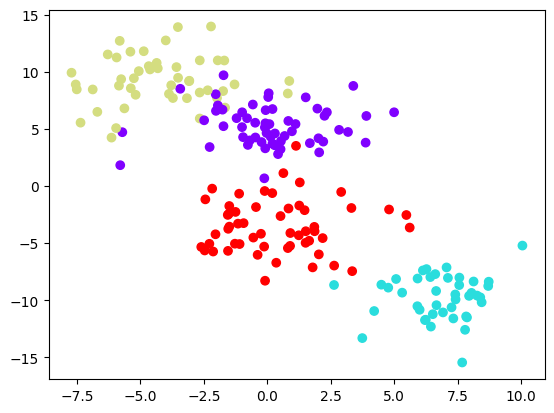

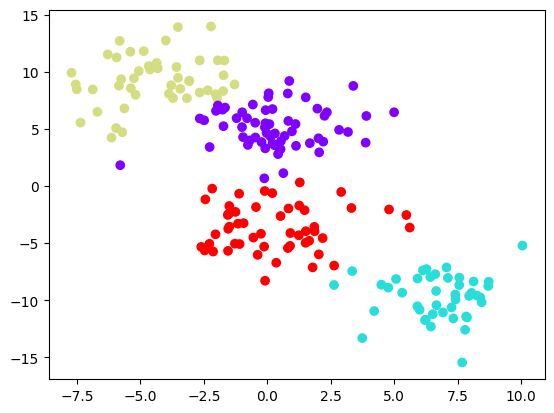

In [198]:
# Visualize!
blob_model_0.eval()
with torch.inference_mode():
  y_test_preds = torch.argmax(torch.softmax(blob_model_0(X_blob_test), dim=1), dim=1)

plt.scatter(X_blob_test[:, 0].cpu(), X_blob_test[:, 1].cpu(), c=y_blob_test.cpu(), cmap="rainbow")
plt.show()
plt.scatter(X_blob_test[:, 0].cpu(), X_blob_test[:, 1].cpu(), c=y_test_preds.cpu(), cmap="rainbow")
plt.show()

In [199]:
y_blob_test

tensor([2, 3, 0, 1, 0, 0, 3, 1, 2, 0, 2, 2, 3, 1, 3, 1, 3, 3, 1, 0, 2, 2, 3, 3,
        1, 0, 3, 0, 0, 0, 2, 1, 1, 1, 0, 2, 1, 1, 3, 1, 1, 1, 2, 2, 0, 0, 3, 1,
        1, 3, 3, 3, 2, 3, 1, 2, 0, 2, 3, 0, 3, 3, 3, 3, 1, 0, 1, 2, 3, 0, 0, 3,
        1, 2, 1, 0, 1, 0, 0, 3, 3, 0, 3, 1, 0, 2, 2, 3, 1, 3, 3, 0, 3, 0, 0, 1,
        2, 0, 2, 0, 1, 0, 3, 0, 1, 2, 2, 0, 3, 0, 1, 3, 1, 3, 0, 1, 2, 0, 2, 0,
        2, 3, 0, 2, 2, 0, 0, 2, 1, 1, 3, 3, 2, 0, 2, 0, 3, 3, 1, 2, 3, 0, 3, 2,
        0, 2, 0, 3, 1, 3, 3, 0, 1, 2, 2, 2, 3, 0, 2, 0, 3, 0, 3, 3, 2, 2, 2, 2,
        1, 1, 3, 0, 1, 2, 2, 3, 0, 0, 3, 0, 0, 1, 0, 1, 0, 3, 1, 2, 3, 0, 2, 2,
        0, 3, 2, 3, 0, 0, 1, 2], device='cuda:0')

In [200]:
y_test_preds

tensor([0, 0, 0, 1, 0, 0, 3, 1, 2, 0, 2, 2, 3, 1, 3, 1, 3, 3, 1, 0, 0, 2, 3, 3,
        1, 2, 3, 0, 0, 0, 2, 1, 1, 1, 0, 2, 1, 1, 3, 1, 1, 1, 2, 2, 0, 0, 3, 1,
        1, 1, 3, 3, 2, 3, 1, 2, 0, 0, 0, 0, 3, 3, 3, 3, 1, 0, 1, 2, 3, 0, 0, 3,
        1, 2, 1, 0, 1, 0, 0, 3, 3, 2, 3, 1, 0, 2, 2, 3, 1, 3, 3, 0, 3, 0, 0, 1,
        2, 0, 2, 0, 1, 0, 3, 0, 1, 2, 0, 0, 3, 0, 1, 3, 1, 3, 0, 1, 2, 2, 2, 0,
        2, 3, 0, 2, 2, 0, 0, 2, 1, 1, 3, 3, 2, 0, 2, 0, 3, 3, 1, 2, 3, 0, 3, 2,
        0, 2, 0, 3, 1, 3, 3, 0, 1, 2, 2, 2, 3, 0, 2, 0, 3, 0, 3, 3, 2, 2, 2, 2,
        1, 1, 3, 2, 1, 2, 2, 3, 0, 0, 3, 0, 0, 1, 0, 1, 0, 3, 1, 2, 3, 0, 2, 2,
        0, 3, 2, 3, 0, 0, 1, 2], device='cuda:0')

## 9. A few more classification metrics to evaluate model

* Accuracy - % right
* Precision
* Recall
* F1-Score

https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

In [201]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 9.3 MB/s eta 0:00:00


In [204]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
torchmetric_accuracy(y_test_preds, y_blob_test)

tensor(0.9450, device='cuda:0')